In [1]:
import json
import re
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# read data from .json file

with open("../datasets/plain_text/plain_statement.json") as f:
    json_data = json.load(f)

plain_sql = [item['sql'] for item in json_data]
plain_sql = [sql.lower() for sql in plain_sql]

In [3]:
# split data into tokens

pattern = r'[\s()\-,:;]'
string_literal_pattern = r"'([^']*)'"
placeholder = "<string>"

# replace content inside single quotes by <string>
plain_sql_ph = [re.sub(string_literal_pattern, placeholder, sql) for sql in plain_sql]

# split the statements with placeholder
tokenized_sql = [re.split(pattern, sql) for sql in plain_sql_ph]

# remove empty tokens
tokenized_sql = [token for token in tokenized_sql if token]

# replace numbers by placeholder
for sql in tokenized_sql:
    for i, token in enumerate(sql):
        # if re.match(r'^[\'\"].*[\'\"]$', token):  # Check if token is a string literal
        #     sql[i] = '<string>'
        if re.match(r'^[0-9]+(\.[0-9]+)?$', token):  # Check if token is a number
            sql[i] = '<number>'

# remove empty tokens
for i, sql in enumerate(tokenized_sql):
    tokenized_sql[i] = [token for token in tokenized_sql[i] if token]

In [4]:
# build the vocab
vocab_set = set()
for sql in tokenized_sql:
    vocab_set.update(sql)

vocab_dict = {word: idx for idx, word in enumerate(vocab_set)}

In [5]:
# get the runtimes
runtime = [item['runtime_ms'] for item in json_data]
runtime = np.array(runtime)

# classify the runtimes, label 0 for runtime <=3000ms, 1 for runtime >3000ms
label = np.where(runtime > 3000, 1, 0)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=vocab_set)
X = vectorizer.fit_transform(plain_sql_ph)
X = X.toarray()
print(len(X))
print(X.shape)

10687
(10687, 77)


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_mat = tfidf_vectorizer.fit_transform(plain_sql_ph)
tfidf_mat = tfidf_mat.toarray()

tfidf_mat.shape
# tfidf_mat.shape

(10687, 16162)

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=16162, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 4030, 512)
        self.fc2 = nn.Linear(512, 2)  # Assuming binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4030)  # Adjust according to the output size of conv2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [59]:
# Set parameters
batch_size = 128 # Batch size
epochs = 20 # Number of epochs
val_split = 0.2 # Test data percentage

In [69]:
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(tfidf_mat, label, test_size=val_split)

X_train_tensor = torch.tensor(X_train).float()  # Convert sparse matrix to dense tensor
y_train_tensor = torch.tensor(y_train).long()
X_test_tensor = torch.tensor(X_test).float()  # Convert sparse matrix to dense tensor
y_test_tensor = torch.tensor(y_test).long()

In [71]:
X_train_tensor.shape

torch.Size([8549, 16162])

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

# Initialize the random forest classifier
clf = LogisticRegression(max_iter=1000)

# Train the random forest classifier
clf.fit(X_train_tensor, y_train_tensor)

# Predict the labels for the test set
y_pred = clf.predict(X_test_tensor)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_tensor, y_pred)
precision = precision_score(y_test_tensor, y_pred)
recall = recall_score(y_test_tensor, y_pred)

In [80]:
print(accuracy, precision, recall)

0.7829747427502338 0.7074626865671642 0.6388140161725068


In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool1D, Conv1D, Embedding, GlobalAvgPool1D
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt # Draw graph

In [8]:
vocab_size = len(vocab_set)
embedding_dim = 10

# Create the model; add convolution layers, pooling layer, etc.
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=vocab_size))
model.add(Conv1D(256,
                3,
                padding = 'same',
                activation = 'relu'))

model.add(MaxPool1D(3,3,padding='same'))
model.add(Conv1D(32,3,padding='same', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 100000, activation = 'softmax'))

model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = "adam",
             metrics = ["accuracy"])

In [9]:
# Set parameters
batch_size = 128 # Batch size
epochs = 20 # Number of epochs
val_split = 0.2 # Test data percentage

# Train the model
# Output shows training loss(loss), training accuracy(accuracy), validation loss(val_loss), and validation accuracy(val_acc)
history = model.fit(
            X,
            label,
            validation_split = val_split,
            batch_size = batch_size,
            epochs = epochs
            )

Epoch 1/20


67/67 [==============================] - 61s 739ms/step - loss: 4.1296 - accuracy: 0.5701 - val_loss: 0.6356 - val_accuracy: 0.6660
Epoch 2/20
67/67 [==============================] - 37s 555ms/step - loss: 0.6255 - accuracy: 0.6623 - val_loss: 0.6215 - val_accuracy: 0.6782
Epoch 3/20
67/67 [==============================] - 26s 396ms/step - loss: 0.5656 - accuracy: 0.6870 - val_loss: 0.6095 - val_accuracy: 0.6656
Epoch 4/20
67/67 [==============================] - 25s 371ms/step - loss: 0.5614 - accuracy: 0.6938 - val_loss: 0.6004 - val_accuracy: 0.6777
Epoch 5/20
67/67 [==============================] - 25s 381ms/step - loss: 0.5546 - accuracy: 0.7018 - val_loss: 0.5620 - val_accuracy: 0.7138
Epoch 6/20
67/67 [==============================] - 25s 374ms/step - loss: 0.5539 - accuracy: 0.7048 - val_loss: 0.5628 - val_accuracy: 0.7166
Epoch 7/20
67/67 [==============================] - 26s 390ms/step - loss: 0.5486 - accuracy: 0.7117 - val_loss: 0.5615 - val_accuracy: 0.69

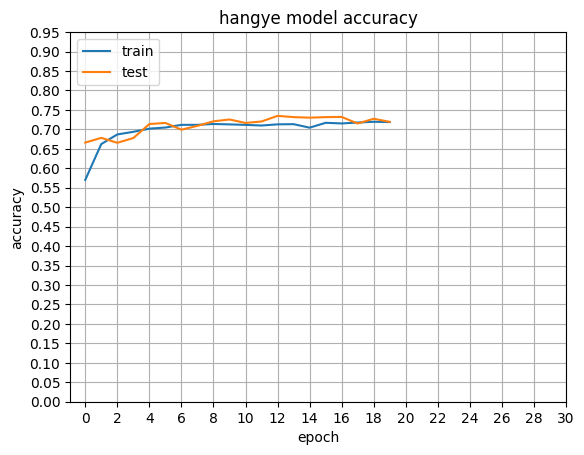

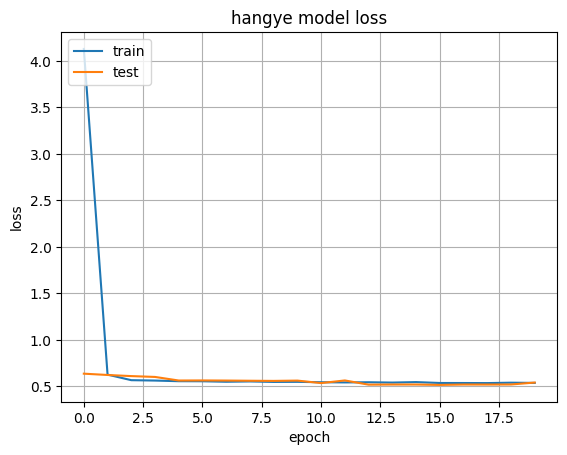

In [11]:
# Draw graph of loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('hangye model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.xticks(np.arange(0,31,2))
plt.yticks(np.arange(0,1,0.05))
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('hangye model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()